<a href="https://colab.research.google.com/github/pvrohin/DS595-Machine-Learning-for-Engineering-and-Science-Applications/blob/main/CaseStudy_3_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BEFORE YOU START!!!

This notebook will run Neural Networks, which can make use of GPU machines to speed up training. **To use GPU in the colab: Click Runtime (Upper left corner) → Change runtime type → Hardware accelerator → T4 GPU → Save**

On the right hand side, if you see the name `T4` and the green checkmark, you're all set!

## Important Note:

Colab will be upset if you reserve a GPU and then do not use it. The GPU will be used after question 4. Thus, Randy really recommends that you do NOT ask for a GPU UNLESS you get past Question 4. If you are doing Questions 1-4, start with a CPU and finish your coding and answering of questions. Once you finish question 4, follow the steps above to SWITCH to a GPU, re-run all of the code cells again, and proceed from there.

### Why do we do this?
If you reserve the GPU and do not use it (in this notebook, train any neural networks), Colab will not like that and after a certain amount of time will
kill your GPU machine and prevent you from reserving a GPU for the day. It can be very annoying, but just keep in mind if you are not running any of the neural network cells, then it is a good idea to use the CPU until you are ready for the training of the neural networks parts. When you are ready, follow the steps above and run all of the cells up unto where you are.

## Electric field Measurement ##

This case study is based upon the excellent real world machine learning problem, you can find more detail below:

[Deep Learning for Range Localization via Over-Water Electromagnetic Signals](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9680246)

**Background:** As a signal moves through the humid air above the ocean, it bounces through layers of humidity known as *evaporation ducts*. This traps and distorts the signal, which you'd think would be bad for us, but it's actually very helpful! This is what allows us to distinguish different signal measurements at different ranges. We have a signal that looks like this:

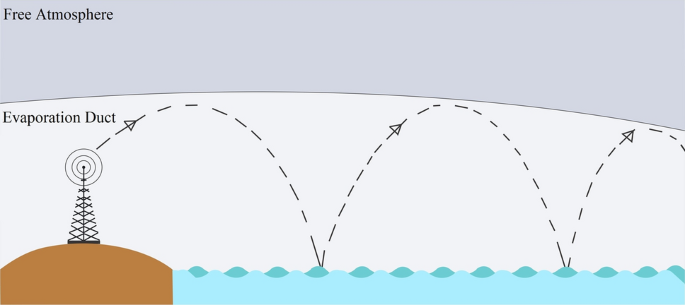


So how do we measure this? Let's imagine there's a boat out on the ocean sending a signal, and we're at a signal receiver on shore. We want to figure out how far away the boat is. In theory, can we even do that?


**Objective:**  Our goal here is to come up with a function that takes in an electromagnetic signal (e.g. radio waves) and output the distance that the signal came from.

**Data:** For this problem, our input data is a measurement of the electric field that we see from the transmitter. We measure the electric field with an antenna:

![](https://20fd661yccar325znz1e9bdl-wpengine.netdna-ssl.com/wp-content/uploads/2021/03/best-outdoor-antenna-scaled-e1616606936465.jpeg)

Do you see the 8 X shaped antennae in the image? Each one of those is a signal receiver. We're measuring in a very similar way, except that instead of 8 receivers, we have 40. Additionally, the fact that the receivers are X shaped is a big deal, since they measure light at different polarizations. As we know, light is a wave, and it can oscillate in any orientation - vertically, horizontally, or anything in between.

![](https://www.specac.com/getattachment/news/calendar/2018/04/polarization-basics/planes-of-polarization.png.aspx?lang=en-GB)

We have to measure both horizontally and vertically to make sure we capture everything - we do this at each of our 40 sensors. Therefore, we essentially have 80 sensors measuring the signal.

Lastly, note that these signals are measured as complex numbers. We don't want to mess around with neural networks of complex numbers, so we will split each complex number into two real numbers before putting them into our data set.

Finally, we end up with 160 dimensional data. So we have 160 features that we can use to predict how far away the transmitter is.

**References:**

Evan Witz el at, Deep Learning for Range Localization via Over-Water Electromagnetic Signals, 2021, ICMLA

### Import Signal Data

In [2]:
# install package

# this is a package that handles a certain file type called HDF5, where our data
# is stored
import h5py


import numpy as np
import matplotlib.pylab as py
import random
import datetime
%matplotlib inline

# These are the packages associated with pytorch, which we will use
# to make our neural network
import torch
import torch.optim as optim
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

import time
import matplotlib.pyplot as plt


from numpy import savetxt
from numpy import loadtxt

Similar to case study 1 and 2, the data can be accessed directly by url.

In [3]:
import requests


def download(url: str, output_path: str, mode: str = "wb") -> None:
    res: requests.Response = requests.get(url)
    if res.status_code != 200:
        raise ValueError(f"download of {url} failed with status code {res.status_code}")
    with open(output_path, mode=mode) as fp:
        fp.write(res.content)


download(
    url="https://raw.githubusercontent.com/rcpaffenroth/DS595-Machine-Learning-for-Engineering-and-Science-Applications/main/data/cs3data1.h5",
    output_path="./cs3data1.h5",
)
download(
    url="https://raw.githubusercontent.com/rcpaffenroth/DS595-Machine-Learning-for-Engineering-and-Science-Applications/main/data/cs3data2.h5",
    output_path="./cs3data2.h5",
)

We grab the data from the file here.

In [4]:
arrays={}

# grab the data from the file
filepath = ['cs3data1.h5']
numfiles = len(filepath)
f = 0
for i in range(numfiles):
    f = h5py.File(filepath[i], 'r')
    for k, v in f.items():
        arrays[k] = v

# display what data we have
for key in arrays.keys():
    print(key, arrays[key])

duct_height_save <HDF5 dataset "duct_height_save": shape (1, 1), type "<f8">
field_H_imag_save <HDF5 dataset "field_H_imag_save": shape (1201, 40), type "<f8">
field_H_real_save <HDF5 dataset "field_H_real_save": shape (1201, 40), type "<f8">
field_V_imag_save <HDF5 dataset "field_V_imag_save": shape (1201, 40), type "<f8">
field_V_real_save <HDF5 dataset "field_V_real_save": shape (1201, 40), type "<f8">
range_grid <HDF5 dataset "range_grid": shape (1201, 1), type "<f8">


Note the `field_H_imag_save` stands for the columns of the imaginary numbers for the horizontal measures, and `field_H_real_save` is for the real numbers for the horizontal measures, likewise for the vertical (V) measures.

In [5]:
numranges = 1201

# get the electric field data and reshape everything into one np array
# don't worry about the details, take note of the final shape of the arrays

data_h_real = np.array(arrays['field_H_real_save']).reshape(numranges, 40)
data_h_imag = np.array(arrays['field_H_imag_save']).reshape(numranges, 40)
data_v_real = np.array(arrays['field_V_real_save']).reshape(numranges, 40)
data_v_imag = np.array(arrays['field_V_imag_save']).reshape(numranges, 40)

Xraw = []
Xraw += [[data_h_real*1, data_h_imag*1, data_v_real*1, data_v_imag*1]]
Xraw = np.block(Xraw)

print(f"Raw data shape: {Xraw.shape}")

# get the range data
ranges = np.zeros((numranges))
ranges = np.array(arrays['range_grid']).reshape((numranges))

yraw = []
yraw += [ranges]
yraw = np.block(yraw)

print(f"Raw target shape: {yraw.shape}")

Raw data shape: (1201, 160)
Raw target shape: (1201,)


### Data preprocessing


Let's take a look at our data points! Here's what an electric field measurement looks like when the transmitter is 15km away, i.e., at a range of 15 km.

<Figure size 640x480 with 0 Axes>

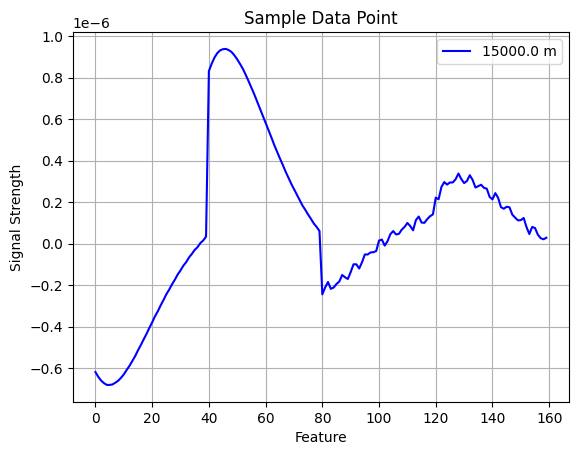

<Figure size 640x480 with 0 Axes>

In [6]:
plt.plot(Xraw[100], c='b', label=f"{yraw[100]} m")
plt.grid()
py.xlabel("Feature")
py.ylabel("Signal Strength")
py.title("Sample Data Point")
plt.legend()
plt.figure()

There's one thing that we have to be careful of before attempting any algorithm on this data - and that is *data snooping*. It is very easy to data snoop on this problem because of the fact that electromagnetic signals get weaker the further you are from the transmitter - think of listening to a radio station and the reception getting weaker the further you are from the city the radio station is in.

Imagine the following: we are given many measurements of an electric field coming from a very powerful emitter. Whatever algorithm we use can directly learn that very strong signals are very close to the transmitter, and weaker signals are far from the emitter. Sounds good right? We train a model and it learns to determine distance from the emitter just based on the strength of the signal coming in. But this does not work.

Imagine next that we test our model on a new data point, but this one comes from a very weak emitter. It will take in a weak signal and predict that we are far from the emitter, even though that may not be the case. In practice, we do not know how strong the emitter is that's putting out the signal. This makes our model useless!

To fix this, we must *normalize* the input data, i.e. change all our data vectors to have norm 1. This removes the strength of the signal from our analysis completely, and forces our method to learn based purely on the shape of the data, not its size.

### What does it mean for our data vectors to have a norm of 1?

In [7]:
def normalize(X):

    normedX = np.zeros_like(X)

    #renormalize
    # First renormalize the first set of real numbers
    normedX[:,0:80] = X[:,0:80] / np.linalg.norm(X[:,0:80], axis=1, keepdims=True).reshape((len(X), 1))

    # Second, renormalize the secnod set of real numbers
    normedX[:,80:160] = X[:,80:160] / np.linalg.norm(X[:,80:160], axis=1, keepdims=True).reshape((len(X), 1))

    return normedX

In [8]:
x_norm=normalize(Xraw)
print(x_norm.shape)

(1201, 160)


<Figure size 640x480 with 0 Axes>

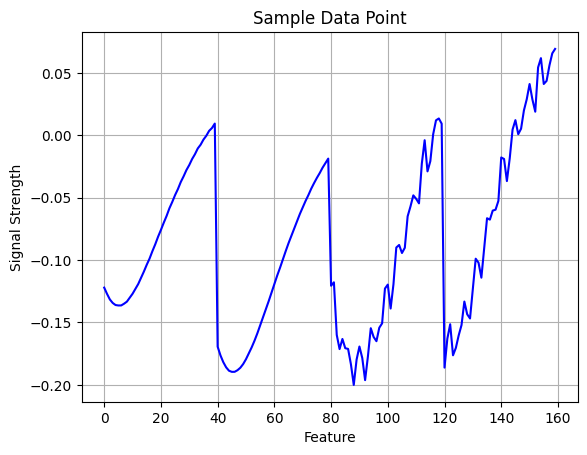

<Figure size 640x480 with 0 Axes>

In [9]:
plt.plot(x_norm[140], c='b')
plt.grid()
py.xlabel("Feature")
py.ylabel("Signal Strength")
py.title("Sample Data Point")
plt.figure()

# Naive solution

### Traditional Regression Modeling

![](https://embarc.online/pluginfile.php/32600/mod_page/content/1/review.jpg)

**Recall:**
Still remember what we did in case study 1? Let's re-implement those algorithms in this case study.

What is the first step? Splitting the training and test set right?

The `train_test_split` is a function in `sklearn` for the specific purpose of splitting data into train and test sets.


In [10]:
from sklearn.model_selection import train_test_split
XTrain,XTest, yTrain, yTest = train_test_split(x_norm, yraw, test_size=0.5, shuffle=True,random_state=1)

print(XTrain.shape)
print(XTest.shape)
print(yTrain.shape)
print(yTest.shape)


(600, 160)
(601, 160)
(600,)
(601,)


In [11]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn import linear_model

In [12]:
def train(XTrain,XTest,yTrain,yTest):
    method = linear_model.LinearRegression()
    model = method.fit(XTrain, yTrain)

    y_pred_train=method.predict(XTrain)
    y_pred_test=method.predict(XTest)

    MAE_train=mean_absolute_error(y_pred_train,yTrain)
    MSE_train=mean_squared_error(y_pred_train,yTrain)
    RMSE_train=np.sqrt(mean_squared_error(y_pred_train,yTrain))
    R2_train=r2_score(y_pred_train,yTrain)

    MAE_test=mean_absolute_error(y_pred_test,yTest)
    MSE_test=mean_squared_error(y_pred_test,yTest)
    RMSE_test=np.sqrt(mean_squared_error(y_pred_test,yTest))
    R2_test=r2_score(y_pred_test,yTest)

    return MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test

In [13]:
from tabulate import tabulate
MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test=train(XTrain,XTest,yTrain,yTest)
results=[["Linear regression",MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test]]

In [14]:
print(tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R2", "Test MAE", "Test MSE", "Test RMSE", "Test R2"],tablefmt="grid"))

+-------------------+----------------+----------------+-----------------+---------------+-------------+-------------+-------------+--------------+
| Model             |   Training MAE |   Training MSE |   Training RMSE |   Training R2 |    Test MAE |    Test MSE |   Test RMSE |      Test R2 |
+===================+================+================+=================+===============+=============+=============+=============+==============+
| Linear regression |        10776.9 |    1.89049e+08 |         13749.5 |     -0.811461 | 1.25807e+06 | 1.31444e+14 | 1.14649e+07 | -0.000278576 |
+-------------------+----------------+----------------+-----------------+---------------+-------------+-------------+-------------+--------------+


## **Question 1** **(20 points)**

**Part 1 (10 points)**
An easy 10 points since we have done this (almost) before :-)
What do MAE, MSE, RMSE and R^2 mean? How are they counted and what is the difference between them? Which is better for describing the performance of your algorithm? Why?

R^2 measures how good the predictions of the regression model match the given
dataset. The value of R^2 ranges from 0 to 1, where 1 indicates a perfect match in prediction and 0 indicates the opposite. In general, a higher R^2 value indicates that the fit to the data by our model is good.

MSE mean is the average of the squared difference between the actual and the predicted values. A high value of MSE, i.e, a high error indicates worse performance and a smaller MSE indicates better performance.

MAE is calculated by taking the average of the absolute difference between the actual values and the predicted values. It gives the average magnitude of the errors without taking into consideration direction.

RMSE is the square root of the MSE. It is often preferred because it gives the error metric in the same units as the target variable, making it more interpretable.

MAE is more robust to outliers when compared to MSE and RMSE since it does not square the errors. MSE and RMSE penalize larger errors more heavily since they are sensitive to outliers. When the objective is to capture the magnitude of the errors, they become more useful. R² provides us with information about the overall fit goodness of the model, but at the same time it does not give us any information regarding the magnitude od the errors. R² closer to 1 indicates a better fit of the model to the data.

In summary, there is no single "best" metric and we should consider multiple metrics to gain a comprehensive understanding of the model's performance.

**Part 2 (10 points)**  

Try at least three different methods such as `KNeighborsRegressor(n_neighbors=20)`, `linear_model.Ridge()`, `linear_model.Lasso()`, or `linear_model.BayesianRidge()`. Can you achieve better performance than the previous model? Report your results in the table below. What are your observations? Please analyze the results.

Linear Regression:

The training and testing MAE are high which means that the model predictions deviate a lot from the ground truth values. The same case is with the training and testing MSE which shows that there is a lot of variane from the ground truth values. The negative R^2 value for both the training and testing sets indicate that the linear regression model performs worse than the horizontal line to fit the data.

KNeighbors Regressor:

The KNN regressor shows improvements in all metrics compared to linear regression. The positive R^2 value indicates that KNN provides a better fit to the data.

Ridge Regression and Lasso Regression:

Both Ridge and Lasso regression models show similar performance to linear regression in terms of MAE, MSE, and RMSE.

Bayesian Ridge Regression:

The Bayesian Ridge Regression model shows similar performance to linear regression, Ridge, and Lasso regression models in terms of MAE, MSE, and RMSE. The very large R^2 valye indicates that this model is not suitable for this data.

Overall, among the evaluated models, the KNeighbors Regressor with n_neighbors=20 appears to perform relatively better in terms of MAE, MSE, RMSE, and R², indicating a better fit to the data compared to the other models.

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, BayesianRidge

## Parts of code generated with Github Co-Pilot

In [16]:
def train_all(XTrain, XTest, yTrain, yTest):
    # Initialize a list to store the results
    results = []

    # Method 1: Linear Regression
    method = linear_model.LinearRegression()
    model = method.fit(XTrain, yTrain)
    results.append(["Linear Regression"] + evaluate_model(method, XTrain, yTrain, XTest, yTest))

    # Method 2: KNeighborsRegressor
    method = KNeighborsRegressor(n_neighbors=20)
    model = method.fit(XTrain, yTrain)
    results.append(["KNeighbors Regressor (n_neighbors=20)"] + evaluate_model(method, XTrain, yTrain, XTest, yTest))

    # Method 3: Ridge Regression
    method = Ridge()
    model = method.fit(XTrain, yTrain)
    results.append(["Ridge Regression"] + evaluate_model(method, XTrain, yTrain, XTest, yTest))

    # Method 4: Lasso Regression
    method = Lasso()
    model = method.fit(XTrain, yTrain)
    results.append(["Lasso Regression"] + evaluate_model(method, XTrain, yTrain, XTest, yTest))

    # Method 5: Bayesian Ridge Regression
    method = BayesianRidge()
    model = method.fit(XTrain, yTrain)
    results.append(["Bayesian Ridge Regression"] + evaluate_model(method, XTrain, yTrain, XTest, yTest))

    return results

def evaluate_model(model, XTrain, yTrain, XTest, yTest):
    # Predictions
    y_pred_train = model.predict(XTrain)
    y_pred_test = model.predict(XTest)

    # Evaluation metrics
    MAE_train = mean_absolute_error(y_pred_train, yTrain)
    MSE_train = mean_squared_error(y_pred_train, yTrain)
    RMSE_train = np.sqrt(mean_squared_error(y_pred_train, yTrain))
    R2_train = r2_score(y_pred_train, yTrain)

    MAE_test = mean_absolute_error(y_pred_test, yTest)
    MSE_test = mean_squared_error(y_pred_test, yTest)
    RMSE_test = np.sqrt(mean_squared_error(y_pred_test, yTest))
    R2_test = r2_score(y_pred_test, yTest)

    return [MAE_train, MSE_train, RMSE_train, R2_train, MAE_test, MSE_test, RMSE_test, R2_test]

# Train the models
results = train_all(XTrain, XTest, yTrain, yTest)

In [17]:
print(tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+---------------------------------------+----------------+----------------+-----------------+----------------+-----------------+-------------+-----------------+----------------+
| Model                                 |   Training MAE |   Training MSE |   Training RMSE |   Training R^2 |        Test MAE |    Test MSE |       Test RMSE |       Test R^2 |
+=======================================+================+================+=================+================+=================+=============+=================+================+
| Linear Regression                     |       10776.9  |    1.89049e+08 |        13749.5  |   -0.811461    |     1.25807e+06 | 1.31444e+14 |     1.14649e+07 |   -0.000278576 |
+---------------------------------------+----------------+----------------+-----------------+----------------+-----------------+-------------+-----------------+----------------+
| KNeighbors Regressor (n_neighbors=20) |        6423.03 |    6.17881e+07 |         7860.54 |    0.551679    |

# Deep Learning

Now that we can move on to deep learning, it's time to train a neural network! Here, we're using a package called PyTorch. It has a lot of built-in tools for coding neural network architechtures and training them. We'll see a few of those in a minute.

![](https://i0.wp.com/semiengineering.com/wp-content/uploads/2018/01/MLvsDL.png?resize=733%2C405&ssl=1)

When training neural networks, we can use different types of hardware and we specify that here. This little bit of code tells PyTorch to figure out whether we're using a GPU or a CPU.

** If you haven't already, to use GPU in the colab: Click Runtime (Upper left corner) → Change runtime type → Hardware accelerator → GPU → Save**. You will then need to re-run all of your cells.


In [18]:
#this is a check to see if a GPU machine that pytorch can use for training
if torch.cuda.is_available():
    print('CUDA available')
    print(torch.cuda.get_device_name(0))
else:
    print('CUDA *not* available')




CUDA *not* available


## **Question 2** **(15 points)**

Before we move on to model training part, Randy 🧙 wants to ask you several questions. Please read the article below and answer the following questions.

https://www.zendesk.com/blog/machine-learning-and-deep-learning/

https://towardsdatascience.com/what-is-a-gpu-and-do-you-need-one-in-deep-learning-718b9597aa0d

**Part 1 (5 points)**

What are the important things that make deep learning different from other machine learning algorithms?

Feature Representation: In contrast to traditional machine learning where domain knowledge is used to extract features from raw data, deep learning models can automatically learn hierarchical representations of features from the raw data.

Architecture Complexity: Deep learning models have multiple layers of interconnected neurons which enable them learn intricate patterns and representations from large volumes of data.

Scalability: Deep learning models scale well with large datasets and high-dimensional data, where traditional machine learning algorithms generally struggle.

End-to-End Learning: Deep learning models can perform end-to-end learning which allows them to learn directly from raw data to output predictions without relying on intermediate processing steps.

**Part 2 (5 points)**

What are the differences between a CPU and a GPU? Is the performance of GPU always superior to that of CPU? why?  

Architecture: CPUs are designed with a few powerful cores for general-purpose computing tasks whereas GPUs on the other hand, have thousands of smaller cores designed for accelerating tasks that involve massive amounts of parallelism, such as graphics rendering.

Parallelism: CPUs excel at handling tasks that require low to moderate levels of parallelism whereas GPUs are highly efficient at processing tasks with high levels of parallelism.

Memory Hierarchy: CPUs typically have larger caches and faster memory access whereas GPUs have smaller caches and rely heavily on fast memory access and high-bandwidth memory.

Regarding the performance of GPUs compared to CPUs, it depends on the nature of the task being performed:

Some tasks may not benefit from parallel processing or may require specialized optimizations to leverage the full potential of the GPU. Additionally, CPUs are typically more versatile and can handle a wider range of tasks efficiently compared to GPUs.

**Part 3 (5 points)**  

Why are GPUs particularly effective for performing efficient deep learning? Explain.

Parallel Processing Power: Parallel architecture enables GPUs to execute computations on large matrices and tensors, which are fundamental to deep learning, much faster compared to CPUs.

Matrix Operations: GPUs are highly optimized for matrix multiplications and convolutions, As a result, GPUs can perform matrix operations much faster than CPUs.

High Memory Bandwidth: GPUs have high memory bandwidth, allowing them to quickly access and transfer large amounts of data between the processor and memory. This is crucial for deep learning tasks, where large neural networks and datasets are commonly used.


#  Neural Network Time

## Important Preliminaries.

Making Neural Networks is more complicated than traditional Machine Learning algorithms we have been using from the `sklearn` package. In order to make building them easier, we use packages like `pytorch` to make building and training them easier. At the same time, `pytorch` is designed to use a programming styple called Object Oriented Programming (OOP), specifically making classes and inheritence, which are software engineering pattern. A common pattern when using `pytorch` is to make a class instance of your network that defines all of the logic while inheriting from a specific `pytorch` class. Therefore, we need to be familiar with Object-Oriented Programming Concepts (OOP).

For those of you who may be unfamiliar with these, here is a brief breakdown of the two. If you are familiar, you may skip to the next section.

### OOP: Classes
1. What is a Class?
  - A class is like a blueprint or template for creating objects in Python.
It defines the attributes (data) and methods (functions) that the objects of that class will have.

  - Creating a Class: To create a class, use the `class` keyword followed by the class name (usually capitalized). Inside the class, you define its attributes (variables) and methods (functions).

Let's take a look at a simple example, and we will go step by step to explain what each part is doing.
  
  ```python
class Dog:
    def __init__(self, name, breed): # this is a special method that says "what attributes/qualities can this class have?
        self.name = name
        self.breed = breed

    def bark(self):
        print(f"{self.name} the {self.breed} says woof!")

```
Let's look at this line by line

```python
class Dog:
```
- This is the manner in which you define a new class and its particular name. Here, we are making a class called `Dog`

```python
class Dog:
  def __init__(self, name, breed):

```
- The next additional line defines what attributes will be associated with this `Dog` object. Here, we want the ability for the `Dog` to have a name and a breed type. We accomplish this by putting these variables in what is called the `__init__()` method. This is a special and reserved function specifically for a class that tells python that the class `Dog` will need these two variables to have an associated `name` and `breed` value when it comes time to instantiate, or make the `Dog`. Remember, the class is like a blueprint of how a certain chunk of code will work, so when it comes time to use this class, we will _instantiate_ it and provide the values for the name and breed, like such:

```python
my_dog = Dog(name="Max", breed="husky")
```
- This makes a new variable `my_dog` that we can use for our own purposes.

You have done this process before! Refer back to Question 1 part 2, when it suggests to use `KNeighborsRegressor(n_neighbors=20)`. In order to use this, we first _instantiate_ the knn model like such:
```python
knn = KNeighborsRegressor(n_neighbors=20)
knn.fit(...)
```
- If we were to look at the source code of the `KNeighborsRegressor`, we will see something similar to:

```python
class KNeighborsRegressor:
  def __init__(self, n_neighbors, other_arg1, other_arg2, ...)
```
- Now, you might notice that weird `self` argument in the `__init__()` function. This is simple python syntax, it refers to the instance of a class. It becomes more clear if we look at more `Dog` code.  

Coming back to our `Dog` example,

  ```python
class Dog:
    def __init__(self, name, breed): # this is a special method that says "what attributes/qualities can this class have?
        self.name = name
        self.breed = breed
```
- The line `self.name = name` _stores_ the name attribute `"Max"` (or whatever name we give when we instantiate the class) into the class itself. This is handy because we may want to define a method within our class that uses that specific name. It is the same logic for `self.breed = breed`.
- If `Dog` is intialized with `my_dog = Dog("max", "husky")`, the `self.name` attribute in the `Dog` class will be stored as `"Max"`, and the `self.breed` attribute will be saved as `"husky"`. To illustrate this, let's _instantiate_ a `Dog` instance and see what the attribute values are

```python
my_dog = Dog(name="Buddy", breed="Husky")
print(my_dog.name) # Output: Max (analogous to self.name, where self = my_dog)
print(my_dog.breed) # Output: Husky (analogous to self.breed, where self = my_dog)
```
- Notice that now `my_dog` is an _instance_ of `Dog`; we can make many different types of dog names and breed combinatioins, and each will have their own unique `name` and `breed` attributes.

The real benefit of doing this is that now we can make methods that still use all the information that is associated with the `Dog` instance. For example, let' make the `bark()` method:

  ```python
class Dog:
    def __init__(self, name, breed): # this is a special method that says "what attributes/qualities can this class have?
        self.name = name
        self.breed = breed

    def bark(self):
        print(f"{self.name} the {self.breed} says woof!")

```
- Notice that in the `bark()` method, we give an argument `self`. This tells the function that the only argument it has access is the particular `Dog` object we are defining, which is represented by `self`, (we put `self` in the `__init__(self, name, breed)` function). So `self` has the attributes `name` and `breed` because we defined it in the `__init__()` method.

To wrap it all together, if we _instantiate_ our `Dog` and use the `bark()` method, what do you think the output will be?

```python
# Creating an instance (object) of the Dog class
my_dog = Dog(name="Max", breed="Husky")
print(my_dog.name) # Output: Max (analogous to self.name, where self = my_dog)
print(my_dog.breed) # Output: Husky (analogous to self.breed, where self = my_dog)
my_dog.bark()  # Output: "Buddy the Husky says woof!"
  ```

In [19]:
class Dog:
  def __init__(self, name, breed):
    self.name = name
    self.breed = breed

  def bark(self):
      print(f"{self.name} the {self.breed} says woof!")

my_dog = Dog("Max", "Husky")
my_dog.bark()


Max the Husky says woof!


### OOP: Inheritance

Now that we have a grasp on what classes are, the second part we need to be familiar with is inheritance. Inheritance in object-oriented programming (OOP) allows a child class (or subclass) to inherit attributes and methods from a parent class (or superclass). It enables code reuse, hierarchy, and modeling relationships between different types of objects. By inheriting from a parent class, the child class gains access to its functionality, promoting efficient and organized code development.

Let's look at an example continuing our `Dog` example.

  ```python
class Dog:
  def __init__(self, name, breed): # this is a special method that says "what attributes/qualities can this class have?
    self.name = name
    self.breed = breed

  def bark(self):
      print(f"{self.name} the {self.breed} says woof!")


class Puppy(Dog):
  def __init__(self, name, breed, age):
    super().__init__(name, breed)
    self.age = age

  def come_here(self):
    print(f"{self.name} the {self.breed} is only {self.age} weeks, too young to listen!!!")

ben = Puppy(name='ben', breed="Golden Retriever", age=10)
ben.come_here() #Outputs: Ben the Golden Retriever is only 10 weeks, too young to listen!!!
ben.bark() # Outputs: Ben the Golden Retriever says woof!

```
Let's break this down step by step:
-  we create a child class called `Puppy` that inherits from the `Dog` class. In other words, we are instructing that `Puppy` will have the same attributes/qualities and functions that `Dog` has. At the same time, the `Puppy` class has an additional attribute called `age`. Since a puppy is a dog, we can write this class to have all the functionality of a `Dog` (like the `bark()` method) without having to explicitly write the `Puppy` class' specific `bark()` function. This makes code more clean and less burdensome overall.
  - Notice now that `Puppy(Dog`) has the `Dog` class in parenthesis. This is the notation to say that `Puppy` is inherting the `Dog` class. We use `super().__init__(name, breed)` to call the constructor of the parent class (`Dog`) and set the name and breed attributes. Think of this as _instantiating_ the `Dog` class within the `Puppy` class like so (just to be clear, below is for illustration, NOT good coding practice):
  ```python
  # this is NOT good code, only for demonstration
  class Puppy:
        def__init__(self, name, breed, age):
          dog = Dog(name, breed)
          self.name = Dog.name
          self.breed = Dog.breed
  ```

  - With the `super(name, breed).__init__()` method, we make a "short-cut" to giving `Puppy` the `name` and `breed` attributes through inheriting those attributes from the `Dog` class. `super` is a specific name given to the Parent (`Dog`) that the child class (`Puppy`) is inherting from.

- Let's take a look at the new function we are defining.
  
  ```python
    def come_here(self):
        print(f"{self.name} the {self.breed} is only {self.age} weeks, too young to listen!!!)
    ```  
  - The `come_here()` method prints a message specific about the puppies, namely that they don't listen!. It's important to note that this method does not belong to the `Dog` class, only to the `Puppy` class.

  ```python
  ben = Puppy(name='Ben', breed="Golden Retriever", age=10)
  ben.come_here() #Outputs: Ben the Golden Retriever is only 10 weeks, too young to listen!!!
  ben.bark() # Outputs: Ben the Golden Retriever says woof!
  ```
  - The key point is this: because `Puppy` is inheriting from the `Dog` class, the `Puppy` class automatically has access to the `bark()` method. As stated before, we don't need to write this method in the `Puppy` class because we are "getting it for free" by inheriting from the `Dog` class.

In summary, the code demonstrates inheritance, where the `Puppy` class inherits attributes and methods from the `Dog` class. By using inheritance, we can create specialized classes (like `Puppy`) that build upon the functionality of a more general class (like `Dog`).


In [20]:
class Dog:
  def __init__(self, name, breed): # this is a special method that says "what attributes/qualities can this class have?
      self.name = name
      self.breed = breed

  def bark(self):
      print(f"{self.name} the {self.breed} says woof!")


class Puppy(Dog):
  def __init__(self, name, breed, age):
    super().__init__(name, breed)
    self.age = age

  def come_here(self):
    print(f"{self.name} the {self.breed} is only {self.age} weeks, too young to listen!!!")

ben = Puppy(name='ben', breed="Golden Retriever", age=10)
ben.come_here() #Outputs: Ben the Golden Retriever is only 10 weeks, too young to listen!!!
ben.bark() # Outputs: Ben the Golden Retriever says woof!

ben the Golden Retriever is only 10 weeks, too young to listen!!!
ben the Golden Retriever says woof!


## Tying it all together.

Now that we are at least familiar with classes and inheritance, it will make understanding how to build neural networks in `pytorch` easier.

We can design a sample neural network architecture here. Let's think about what kind of architecture we want. We know our input is 160 dimensional, so the input to the first layer has to be of size 160. Our output is a single number for a range estimate, so our output has to be 1 dimensional. Everything in between is up to us. And how do we decide what kind of architecture we want? We make it up! At least at first.

This example has 2 layers of size 160 -> 50 -> 1.

In [21]:
import torch.nn as nn
class mynetwork_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,50),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

Let's go over how this network is structured:

```python
class mynetwork_1(nn.Module):
    def __init__(self):
        super().__init__()

```
This creates a class `mynetwork_1`, in which it is inheriting from a module called `torch.nn.Module`. The `torch.nn.Module` is a class from the `pytorch` library that is specifically designed to be inherited from in order to make custom networks in classes easier to build. Notice we are using the `super().__init__()` method to inherit all the functionality that `nn.Module` has.

```python
class mynetwork_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,50),
            nn.Linear(50, 1)
        )
```
The next line defines a neural network blueprint. It is a special kind of class, `nn.Sequential`, which in simple terms is a container for holding specific layer types. The specific layers we will use are:
1. a Linear layer that has an input size of 160 and an output size of 50, and
2. another Linear layer that has an input size of 50 and an output size of 1.

This is the heart of our neural network, the 2 layers are designed such that when they are passed our raw data, they will outupt a singular value. We instantiate them in order within the `nn.Sequential` class, so that we can treat the two layers as one main pipeline. The output of the first linear layer will automatically be passed as input to the second linear layer, and the output of the second linear layer will be returned for us.

Let's look at our one specific function we have defined

```python
    def forward(self, x):
        x = self.structure(x)
        return x
```
This function is **required** for every class you create when inheriting from `torch.nn.Module`.  It defines the flow of the data for your network. Speficically in our network and our simple case, it defines that an input, `x`, which will be our raw data, is passed through the `self.structure` attribute, which is our container for our linear layers. It returns the final ouput, which will be a scalar value.

And that's it for defining a neural network! The keys are
  1. Inherit from `torch.nn.Module` and run the `super().__init__()` within the `def __init__(self)` method
  2. Define your layers, typically in the `nn.Sequential` object
  3. Define the `forward(self, x)` function that tells how the final output will be made.  

Let's make another another network to compare how a different architecture choice will affect the model.

In [22]:
class mynetwork_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,50),
            nn.Sigmoid(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

## **Question 3** **(5 points)**

**Part 1 (5 points)**

Comparing the two network structures above, what is the difference between them? In other words, what is `nn.Sigmoid()`, why do we need it? Can both networks perform nonlinearity? why?

The difference between the two network structures lies in the presence of the nn.Sigmoid() layer in mynetwork_2. Sigmoid() is an activation function that squishes the input values between 0 and 1. This function is commonly used to introduce nonlinearity to the network's output. It's particularly useful in binary classification tasks where the output needs to be interpreted as probabilities.

Sigmoid introduces nonlinearity to the network, allowing it to learn more complex relationships between the input and output.

Both networks cannot perform nonlinearity. In mynetwork_1, there is no explicit nonlinearity introduced between the two linear layers. On the other hand, mynetwork_2 introduces nonlinearity through the nn.Sigmoid() activation function, allowing it to capture more complex relationships in the data.

Next we need to choose some training settings:

`batch size`

`number of epochs`

`learning rate`

`criterion (loss function)`

## **Question 4** **(10 points)**

Randy 🧙 wants you to know what they are, rather than just turning the numbers. Please read the article below and answer the following questions.

https://blog.paperspace.com/intro-to-optimization-in-deep-learning-gradient-descent/

https://towardsdatascience.com/what-are-hyperparameters-and-how-to-tune-the-hyperparameters-in-a-deep-neural-network-d0604917584a

**Part 1 (5 points)**

Explain how neural network optimize its parameters (weights) using gradient descent. Does it always guarantee to find the global minima? why?

Parameter optimization using Gradient Descent involves the following steps:

Forward Pass: The input data is passed through a set of layers pre-defined in the neural network. In each layer, we apply some wieghts to the input proceeded by an activation function to produce an output.

Loss Calculation: A loss function is defined to calculate the difference between the predicted and the actual values. We can MSE (Mean Squared Error), Cross-Entropy which are commonly used loss functions

Backpropagation: The heart off backpropagation lies in the chain rule where the gradients of the loss function with respect to the weights are calculated using the chain rule. Then the errors are propagated backwards all the way till the first layer.

Gradient Descent Update: The weights of the neural network are updated iteratively using the following formula:

new_weight
=
old_weight
−
learning_rate
×
gradient
new_weight=old_weight−learning_rate×gradient

The above steps are repeated until convergence criteria are met.

Gradient descent does not always guarantee to find the global minima of the loss function. There are several reasons for this:

Non-Convex Loss Surfaces: If the loss function is non-convex i.e it has multiple local minimas, saddle points and plateaus, then gradient descent might fail to find the global minimum.

Learning Rate Selection: If the learning rate is too high, gradient descent may overshoot the minima and, if the learning rate is too low, convergence may be slow or we may get stuck in one of the local minimas.

Initialization Sensitivity: Poor initialization can lead to suboptimal convergence to suboptimal or getting stuck in local minima.

**Part 1 (5 points)**

What are `batch size`, `number of epochs`, `learning rate`, `criterion (loss function)`? How do they impact the optimization of neural networks?

Batch Size: Batch size is the number of training examples utilized in one iteration. Larger batch sizes generally lead to faster training. Smaller batch sizes can provide noisy parameter updates but may converge to better solutions.

Number of Epochs: The number of epochs defines how many times the learning algorithm will work through the entire training dataset. More the number of epochs, the model can learn more complex patterns. Sometimes, higher epoch numbers will lead to overfitting

Learning Rate: The learning rate determines the step size at each iteration while moving toward a minimum of a loss function during training.
A higher learning rate allows for faster convergence but may lead to overshooting the minimum. A lower learning rate provides slower but more precise convergence.

Criterion (Loss Function): Common loss functions include Mean Squared Error (MSE), Cross-Entropy Loss (Binary or Categorical). Choosing an appropriate loss function depends on the task at hand (regression, classification, etc.) and the characteristics of the dataset. During training, the goal is to minimize the loss function, adjusting the model parameters (weights) accordingly.

Impact on Optimization:

The choice of these hyperparameters can impact convergence speed, model generalization, and the ability to escape local minima. Proper tuning of these hyperparameters through experimentation and validation is crucial for achieving optimal neural network performance.



### **Traning Network**

Now you know what the hyperparameters are. As we might guess, the more epochs we decide to use, the longer it will take and (hopefully) the better accuracy we get. We'll start with 500 in this example. We also have to specify our criterion, or our Loss function. The standard one is to use mean squared error (MSE), which is the standard loss function.

### Now is the time where you can switch to a GPU if you would like (refer to beginning of notebook for how to do that)

### One last `pytorch` note:

Remember when we trained `sklearn` models that the models expected the input be a `numpy.ndarray` object? With `pytorch`, we can't use those `numpy` objects, they need to be another type of array called a `torch.Tensor`. The term `Tensor` is analagous to the `ndarray`, but is is specialized for `pytorch`. So in the code below, you will see many times we are converting our raw data that we downloaded from the url, which is a `numpy.ndarray` into something else, specifically as a `torch.Tensor` object to be compatable with our neural network defined above.  

In [23]:
torch.manual_seed(50) # this makes results reproducable

# If using a GPU, use option 1, if not, use option 2.
 # (If we using GPU, we need to place the class we defined to be put onto the GPU)

# 1
# this says " if there is a GPU, make sure my model can be used on the GPU"
# "if a GPU is not available, then use the CPU"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_1 = mynetwork_1().to(DEVICE)
model_2 = mynetwork_2().to(DEVICE)


# 2
#model = mynetwork()

#training settings
batch_size = 100
num_epochs = 500
learning_rate = 1e-3
criterion = nn.MSELoss()

# print interval during the training
print_interval=20

# what this does is save the actual gpu device to a variable.
# in the next cell, we will use this `device` variable
# to say "make my data compatable with my model if it is on the GPU"


In [24]:
def train(training_inputs, training_outputs, network, epochs, learning_rate,
          batch_size, loss_function, print_interval):
  """
  Trains a neural network model using the specified parameters.

  Args:
      training_inputs (numpy.ndarray): Input data (features) for training.
      training_outputs (numpy.ndarray): Target outputs (labels) for training.
      network (torch.nn.Module): The neural network model to be trained.
      epochs (int): Number of training epochs.
      learning_rate (float): Learning rate for optimization.
      batch_size (int): Batch size for mini-batch gradient descent.
      loss_function (torch.nn.Module): Loss function for optimization.
      print_interval (int): Interval for printing training progress.

  Returns:
      None
  """

  # Step 1: convert numpy data to tensor data for pytorch. Feeding numpy data to
  # a pytorch model will create errors.

  # Notice we are doing two things here
  # 1. We convert both the input and target numpy arrays into a torch.Tensor
  # using the convenient torch.from_numpy() function.
  # PyTorch models don't work with numpy data!!
  # 2. We then are wrapping this tensor into a TensorDataset class. We will skip
  # the details of this, but this is needed for the next line.
  # Just know that whenever your input is originally a numpy array,
  # you will follow this pattern to get it set up correctly for you pytorch model
  train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(training_inputs).float(),
                                                 torch.from_numpy(training_outputs).float())

  # we wrap the TensorDataset into what is called a DataLoader.
  # Recall in sklearn models, we pass the entire training dataset at once into the
  # model. With neural networks, we instead pass a chunk/batch of data into the model,
  # get its outputs, and update the parameters based on this chunk. Then we pass
  # the next chunk and repeat until a desired number of iterations.

  # a dataloader is a special pytorch class that formats the data to create
  # these chunks so that in your training loop, you can pass a chunk in one at a time,
  # update your parameters based on the chunck, and repeat.
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True)

  # The optimizer is the object that will update the parameters of your model,
  # here we need to instantiate it first. The first argument, `network.parameters()`,
  # says "here are the parameters you will be updating".
  optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate, weight_decay=1e-5)
  track_losses = np.zeros(epochs)

  start = time.time()

  # here is the main part of the training procedure.
  for epoch in range(1, epochs+1):

      # the following line says "loop through all the chunks that exist in my data"
      # each chunk is a tuple object, the first argument is the data (assigned
      # to X), the second argument is the target (assigned to y)
      for batch_idx, (X, y) in enumerate(train_loader):
          # grab the x's for this batch
          data = X

          # we have placed our model onto the gpu; we must also ensure that the
          # inputs to the model are also compatable with the gpu, so we manually tell
          # pytorch to place our `data` variable onto the GPU machine so that
          # our model (also on the GPU) can work with it.
          data = data.to(DEVICE)

          # find the predictions f(x) for this batch using the forward() method
          output = network.forward(data)

          # find the loss. This calculates MSE using the pytorch version of MSE
          # ('criterion` in previous cell)
          loss = loss_function(output, y.view([-1, 1]).to(DEVICE))

          # compute the gradient and update the network parameters
          # the gradient are the values calculated from how well the model
          # predicted the target for this batch/chunk, and they will be added
          # to the model parameters so that the model will perform better on the
          # next chunk of data.

          # this says make all gradients equal to 0 (if you don't, they will
          # include the gradients of the previous chucnk, so you are accidentally
          # adding with values that do not apply to the current chunk,
          # which you do not want)
          optimizer.zero_grad()

          # "calculate the gradients for the model parameters"
          loss.backward()

          # "add the gradients to the model parameters"
          optimizer.step()

      # housekeeping - keep track of our losses and print them as we go
      training_loss = loss.item()**.5
      track_losses[epoch-1] = training_loss
      if epoch % print_interval == 0:
          print('epoch: %4d training loss:%10.3e time:%7.1f'%(epoch, training_loss, time.time()-start))

  return network, track_losses

In [25]:
network_1, losses = train(XTrain, yTrain, model_1, num_epochs, learning_rate, batch_size, criterion, print_interval)
network_2, losses = train(XTrain, yTrain, model_2, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:   20 training loss: 4.352e+04 time:    0.4
epoch:   40 training loss: 4.311e+04 time:    0.6
epoch:   60 training loss: 4.254e+04 time:    0.8
epoch:   80 training loss: 4.564e+04 time:    1.0
epoch:  100 training loss: 4.338e+04 time:    1.3
epoch:  120 training loss: 4.120e+04 time:    1.5
epoch:  140 training loss: 4.542e+04 time:    1.7
epoch:  160 training loss: 4.226e+04 time:    2.0
epoch:  180 training loss: 4.191e+04 time:    2.2
epoch:  200 training loss: 4.350e+04 time:    2.5
epoch:  220 training loss: 4.272e+04 time:    2.7
epoch:  240 training loss: 4.434e+04 time:    2.9
epoch:  260 training loss: 4.217e+04 time:    3.3
epoch:  280 training loss: 4.516e+04 time:    3.6
epoch:  300 training loss: 4.234e+04 time:    4.0
epoch:  320 training loss: 4.353e+04 time:    4.3
epoch:  340 training loss: 4.416e+04 time:    4.7
epoch:  360 training loss: 4.318e+04 time:    5.1
epoch:  380 training loss: 4.250e+04 time:    5.3
epoch:  400 training loss: 4.079e+04 time:    5.5


### **Evaluation**

Now, we need to evaluate our network.

In [26]:
def model_eva(XTrain,XTest,yTrain,yTest,model):
  """
  Evaluates a machine learning model's performance on training and test data.

  Args:
    XTrain (numpy.ndarray): Training input features.
    XTest (numpy.ndarray): Test input features.
    yTrain (numpy.ndarray): Actual training target values.
    yTest (numpy.ndarray): Actual test target values.
    model (torch.nn.Module): Trained PyTorch model.

  Returns:
    tuple: A tuple containing the following evaluation metrics:
    - MAE_train (float): Mean Absolute Error on the training set.
    - MSE_train (float): Mean Squared Error on the training set.
    - RMSE_train (float): Root Mean Squared Error on the training set.
    - R2_train (float): R-squared (coefficient of determination) on the training set.
    - MAE_test (float): Mean Absolute Error on the test set.
    - MSE_test (float): Mean Squared Error on the test set.
    - RMSE_test (float): Root Mean Squared Error on the test set.
    - R2_test (float): R-squared (coefficient of determination) on the test set.
  """
  # since we have placed our model onto the gpu, we must also ensure that the
  # inputs to the model are also compatable with the gpu, so we manually tell
  # pytorch to make a new Tensor from our numpy array, and add the .cuda() to
  # ensure that this new tensor is GPU-compatable.
  XTrain_th = torch.from_numpy(XTrain).float().to(DEVICE)
  XTest_th = torch.from_numpy(XTest).float().to(DEVICE)
  #yTrain_th=torch.Tensor(yTrain).cuda()
  #yTest_th=torch.Tensor(yTest).cuda()

  # get predictions on the training set
  yTrain_pred = model.forward(XTrain_th)

  # since we are using sklearn functions, these must be numpy arrays,
  # so we manually change them from torch.Tensors to np.ndarray's
  yTrain_pred_np = yTrain_pred.cpu().detach().numpy().reshape(-1)

  yTest_pred = model.forward(XTest_th)
  yTest_pred_np = yTest_pred.cpu().detach().numpy().reshape(-1)

  MAE_train=mean_absolute_error(yTrain_pred_np,yTrain)
  MSE_train=mean_squared_error(yTrain_pred_np,yTrain)
  RMSE_train=np.sqrt(mean_squared_error(yTrain_pred_np,yTrain))
  R2_train=r2_score(yTrain_pred_np,yTrain)

  MAE_test=mean_absolute_error(yTest_pred_np,yTest)
  MSE_test=mean_squared_error(yTest_pred_np,yTest)
  RMSE_test=np.sqrt(mean_squared_error(yTest_pred_np,yTest))
  R2_test=r2_score(yTest_pred_np,yTest)

  return MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test

In [27]:
MAE_train_nn1,MSE_train_nn1,RMSE_train_nn1,R2_train_nn1,MAE_test_nn1,MSE_test_nn1,RMSE_test_nn1,R2_test_nn1 = model_eva(XTrain,XTest,yTrain,yTest,network_1)
MAE_train_nn2,MSE_train_nn2,RMSE_train_nn2,R2_train_nn2,MAE_test_nn2,MSE_test_nn2,RMSE_test_nn2,R2_test_nn2 = model_eva(XTrain,XTest,yTrain,yTest,network_2)

results.append(["NN_1",MAE_train_nn1,MSE_train_nn1,RMSE_train_nn1,R2_train_nn1,MAE_test_nn1,MSE_test_nn1,RMSE_test_nn1,R2_test_nn1])
results.append(["NN_2",MAE_train_nn2,MSE_train_nn2,RMSE_train_nn2,R2_train_nn2,MAE_test_nn2,MSE_test_nn2,RMSE_test_nn2,R2_test_nn2])


In [28]:
print(tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+---------------------------------------+----------------+----------------+-----------------+-----------------+-----------------+-------------+-----------------+-----------------+
| Model                                 |   Training MAE |   Training MSE |   Training RMSE |    Training R^2 |        Test MAE |    Test MSE |       Test RMSE |        Test R^2 |
+=======================================+================+================+=================+=================+=================+=============+=================+=================+
| Linear Regression                     |       10776.9  |    1.89049e+08 |        13749.5  |    -0.811461    |     1.25807e+06 | 1.31444e+14 |     1.14649e+07 |    -0.000278576 |
+---------------------------------------+----------------+----------------+-----------------+-----------------+-----------------+-------------+-----------------+-----------------+
| KNeighbors Regressor (n_neighbors=20) |        6423.03 |    6.17881e+07 |         7860.54 |     0.

This result does not seem to be very good, so let's try increasing the number of network layers.

In [29]:
class mynetwork_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,100),
            nn.LeakyReLU(), # this is a different type of activation function
            nn.Linear(100,80),
            nn.LeakyReLU(), # it has a similar affect as nn.Sigmoid()
            nn.Linear(80,50),
            nn.LeakyReLU(), # But what is the key difference?
            nn.Linear(50,1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

In [30]:
model_3 = mynetwork_3().to(DEVICE)
network_3, losses = train(XTrain, yTrain, model_3, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:   20 training loss: 4.229e+04 time:    0.4
epoch:   40 training loss: 2.494e+04 time:    0.7
epoch:   60 training loss: 1.907e+04 time:    1.0
epoch:   80 training loss: 1.649e+04 time:    1.4
epoch:  100 training loss: 1.264e+04 time:    1.7
epoch:  120 training loss: 1.135e+04 time:    2.0
epoch:  140 training loss: 8.795e+03 time:    2.3
epoch:  160 training loss: 7.032e+03 time:    2.8
epoch:  180 training loss: 7.253e+03 time:    3.3
epoch:  200 training loss: 5.819e+03 time:    3.8
epoch:  220 training loss: 5.139e+03 time:    4.4
epoch:  240 training loss: 4.820e+03 time:    4.8
epoch:  260 training loss: 4.437e+03 time:    5.1
epoch:  280 training loss: 4.659e+03 time:    5.5
epoch:  300 training loss: 3.736e+03 time:    5.8
epoch:  320 training loss: 3.720e+03 time:    6.1
epoch:  340 training loss: 3.628e+03 time:    6.5
epoch:  360 training loss: 3.766e+03 time:    6.8
epoch:  380 training loss: 3.396e+03 time:    7.1
epoch:  400 training loss: 3.188e+03 time:    7.5


We can plot the training loss by epochs.

<Figure size 640x480 with 0 Axes>

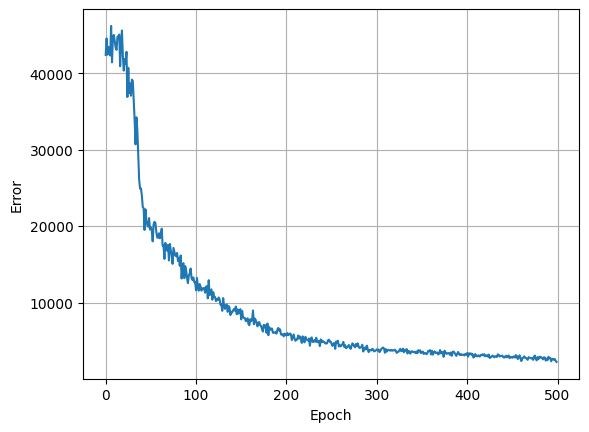

<Figure size 640x480 with 0 Axes>

In [31]:
plt.plot(losses)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")

plt.figure()

In [32]:
MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3 = model_eva(XTrain,XTest,yTrain,yTest,network_3)
results.append(["NN_3",MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+---------------------------------------+----------------+----------------+-----------------+-----------------+-----------------+-------------+-----------------+-----------------+
| Model                                 |   Training MAE |   Training MSE |   Training RMSE |    Training R^2 |        Test MAE |    Test MSE |       Test RMSE |        Test R^2 |
+=======================================+================+================+=================+=================+=================+=============+=================+=================+
| Linear Regression                     |       10776.9  |    1.89049e+08 |        13749.5  |    -0.811461    |     1.25807e+06 | 1.31444e+14 |     1.14649e+07 |    -0.000278576 |
+---------------------------------------+----------------+----------------+-----------------+-----------------+-----------------+-------------+-----------------+-----------------+
| KNeighbors Regressor (n_neighbors=20) |        6423.03 |    6.17881e+07 |         7860.54 |     0.

![](https://media.makeameme.org/created/its-magic.jpg)

Look at this result! Now you know the power of neural networks! But that's not the limit of it. Now it's time to design your own network.

## **Question 5** **(10 points)**

**Part 1 (5 points)**

You should notice that we have changed the activation function from `nn.Sigmoid()` to `nn.LeakyReLU()`. Please explain the difference between `nn.Sigmoid()`, `nn.LeakyReLU()` and `nn.ReLU()`. What are their advantages and disadvantages respectively.

Sigmoid Function (nn.Sigmoid()): The sigmoid function brings the input values into the range from [0, 1]. It is mainly used in binary classification where the output is expressed in terms of probabiities.

Advantages:
It has a smooth gradient, hence it facilitates gradient descent optimization.

Disadvantages:
The vanishing gradient problem is present with this activation function which leads to slower convergence and non zero-centered outputs.

ReLU (Rectified Linear Unit) Function (nn.ReLU()): The Relu is a simple activation function where it returns the input itself for non-negative values and for negative values, the output is clipped to zero.

Advantages:
Simple and computationally efficient, leading to faster training.
Helps avoid the vanishing gradient problem.
Disadvantages:
Prone to the "dying ReLU" problem, where neurons become inactive if the input is always negative.


Leaky ReLU Function (nn.LeakyReLU()): Leaky ReLU is a variant of ReLU that allows a small, non-zero gradient when the input is negative.

Advantages:
Helps solve the dying ReLU problem by allowing a small gradient for negative inputs, promoting better training stability.
Disadvantages:
Introduces a hyperparameter (slope of the negative part) that needs to be tuned.

**Part 1 (5 points)**

Replace the activation functions in `mynetwork_3()` with `nn.Sigmoid()` and `nn.ReLU()` and report the results in the following table. Which activation function performs best and why?

The implementation is as shown below. Relu performs better than Sigmoid in this case. It is simple and a computationally efficient function, leading to faster training compared to sigmoid. It helps us solve the vanishing gradient problem by avoiding saturation in the positive region, promoting faster convergence.


In [33]:
class mynetwork_3_sigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,100),
            nn.Sigmoid(), # this is a different type of activation function
            nn.Linear(100,80),
            nn.Sigmoid(), # it has a similar affect as nn.Sigmoid()
            nn.Linear(80,50),
            nn.Sigmoid(), # But what is the key difference?
            nn.Linear(50,1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

In [34]:
class mynetwork_3_relu(nn.Module):
    def __init__(self):
        super().__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,100),
            nn.ReLU(), # this is a different type of activation function
            nn.Linear(100,80),
            nn.ReLU(), # it has a similar affect as nn.Sigmoid()
            nn.Linear(80,50),
            nn.ReLU(), # But what is the key difference?
            nn.Linear(50,1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

In [35]:
model_3_sigmoid = mynetwork_3_sigmoid().to(DEVICE)
network_3_sigmoid, losses_sigmoid = train(XTrain, yTrain, model_3_sigmoid, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:   20 training loss: 4.216e+04 time:    0.3
epoch:   40 training loss: 4.096e+04 time:    0.7
epoch:   60 training loss: 4.416e+04 time:    1.0
epoch:   80 training loss: 4.418e+04 time:    1.4
epoch:  100 training loss: 4.319e+04 time:    1.7
epoch:  120 training loss: 4.064e+04 time:    2.0
epoch:  140 training loss: 4.376e+04 time:    2.4
epoch:  160 training loss: 4.383e+04 time:    2.7
epoch:  180 training loss: 4.385e+04 time:    3.0
epoch:  200 training loss: 4.287e+04 time:    3.4
epoch:  220 training loss: 4.298e+04 time:    3.7
epoch:  240 training loss: 4.336e+04 time:    4.0
epoch:  260 training loss: 4.328e+04 time:    4.3
epoch:  280 training loss: 4.222e+04 time:    4.7
epoch:  300 training loss: 4.270e+04 time:    5.0
epoch:  320 training loss: 4.330e+04 time:    5.3
epoch:  340 training loss: 4.737e+04 time:    5.8
epoch:  360 training loss: 4.235e+04 time:    6.3
epoch:  380 training loss: 4.289e+04 time:    6.9
epoch:  400 training loss: 4.320e+04 time:    7.5


In [36]:
model_3_relu = mynetwork_3_relu().to(DEVICE)
network_3_relu, losses_relu = train(XTrain, yTrain, model_3_relu, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:   20 training loss: 4.338e+04 time:    0.4
epoch:   40 training loss: 3.029e+04 time:    0.7
epoch:   60 training loss: 1.958e+04 time:    1.0
epoch:   80 training loss: 1.869e+04 time:    1.3
epoch:  100 training loss: 1.577e+04 time:    1.7
epoch:  120 training loss: 1.320e+04 time:    2.0
epoch:  140 training loss: 1.214e+04 time:    2.3
epoch:  160 training loss: 9.424e+03 time:    2.6
epoch:  180 training loss: 8.512e+03 time:    2.9
epoch:  200 training loss: 7.322e+03 time:    3.3
epoch:  220 training loss: 7.233e+03 time:    3.6
epoch:  240 training loss: 6.078e+03 time:    4.0
epoch:  260 training loss: 5.909e+03 time:    4.3
epoch:  280 training loss: 4.884e+03 time:    4.7
epoch:  300 training loss: 4.617e+03 time:    5.1
epoch:  320 training loss: 4.884e+03 time:    5.6
epoch:  340 training loss: 4.417e+03 time:    6.0
epoch:  360 training loss: 3.755e+03 time:    6.4
epoch:  380 training loss: 3.932e+03 time:    6.8
epoch:  400 training loss: 3.892e+03 time:    7.3


In [37]:
MAE_train_nn3_sigmoid,MSE_train_nn3_sigmoid,RMSE_train_nn3_sigmoid,R2_train_nn3_sigmoid,MAE_test_nn3_sigmoid,MSE_test_nn3_sigmoid,RMSE_test_nn3_sigmoid,R2_test_nn3_sigmoid = model_eva(XTrain,XTest,yTrain,yTest,network_3_sigmoid)
MAE_train_nn3_relu,MSE_train_nn3_relu,RMSE_train_nn3_relu,R2_train_nn3_relu,MAE_test_nn3_relu,MSE_test_nn3_relu,RMSE_test_nn3_relu,R2_test_nn3_relu = model_eva(XTrain,XTest,yTrain,yTest,network_3_relu)

In [38]:
results.append(["NN_3_sigmoid",MAE_train_nn3_sigmoid,MSE_train_nn3_sigmoid,RMSE_train_nn3_sigmoid,R2_train_nn3_sigmoid,MAE_test_nn3_sigmoid,MSE_test_nn3_sigmoid,RMSE_test_nn3_sigmoid,R2_test_nn3_sigmoid])
results.append(["NN_3_relu",MAE_train_nn3_relu,MSE_train_nn3_relu,RMSE_train_nn3_relu,R2_train_nn3_relu,MAE_test_nn3_relu,MSE_test_nn3_relu,RMSE_test_nn3_relu,R2_test_nn3_relu])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+---------------------------------------+----------------+----------------+-----------------+-----------------+-----------------+-------------+-----------------+-----------------+
| Model                                 |   Training MAE |   Training MSE |   Training RMSE |    Training R^2 |        Test MAE |    Test MSE |       Test RMSE |        Test R^2 |
+=======================================+================+================+=================+=================+=================+=============+=================+=================+
| Linear Regression                     |       10776.9  |    1.89049e+08 |        13749.5  |    -0.811461    |     1.25807e+06 | 1.31444e+14 |     1.14649e+07 |    -0.000278576 |
+---------------------------------------+----------------+----------------+-----------------+-----------------+-----------------+-------------+-----------------+-----------------+
| KNeighbors Regressor (n_neighbors=20) |        6423.03 |    6.17881e+07 |         7860.54 |     0.

## **Question 6** **(10 points)**

**Part 1 (10 points)**

Design at least 3 different neural network structures and train them (e.g., different number of network layers, different number of neurons, different activation functions, etc.). Please report your results, you should be able to design one that is superior to `NN_3`. (Hint: You may need to tune your hyperparameters (`batch size`, `number of epochs`, `learning rate`) to get higher performance.)


In [39]:
class mynn1(nn.Module):
    def __init__(self):
        super().__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,100),
            nn.ReLU(), # this is a different type of activation function
            nn.Linear(100,80),
            nn.ReLU(), # it has a similar affect as nn.Sigmoid()
            nn.Linear(80,50),
            nn.ReLU(), # But what is the key difference?
            nn.Linear(50,30),
            nn.ReLU(),
            nn.Linear(30,1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

In [40]:
batch_size = 32
num_epochs = 1000
learning_rate = 1e-3
criterion = nn.MSELoss()

In [41]:
mynn1_model = mynn1().to(DEVICE)
mynn1_network, losses_mynn1 = train(XTrain, yTrain, mynn1_model, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:   20 training loss: 1.564e+04 time:    1.1
epoch:   40 training loss: 1.005e+04 time:    1.9
epoch:   60 training loss: 7.465e+03 time:    2.7
epoch:   80 training loss: 4.156e+03 time:    3.6
epoch:  100 training loss: 4.580e+03 time:    4.6
epoch:  120 training loss: 3.590e+03 time:    5.5
epoch:  140 training loss: 2.486e+03 time:    6.4
epoch:  160 training loss: 3.063e+03 time:    7.3
epoch:  180 training loss: 2.907e+03 time:    8.3
epoch:  200 training loss: 2.191e+03 time:    9.3
epoch:  220 training loss: 2.596e+03 time:   10.2
epoch:  240 training loss: 2.022e+03 time:   11.3
epoch:  260 training loss: 3.019e+03 time:   12.7
epoch:  280 training loss: 1.747e+03 time:   13.7
epoch:  300 training loss: 2.090e+03 time:   14.6
epoch:  320 training loss: 1.409e+03 time:   15.5
epoch:  340 training loss: 1.424e+03 time:   16.5
epoch:  360 training loss: 1.041e+03 time:   17.4
epoch:  380 training loss: 1.540e+03 time:   18.4
epoch:  400 training loss: 8.014e+02 time:   19.3


<Figure size 640x480 with 0 Axes>

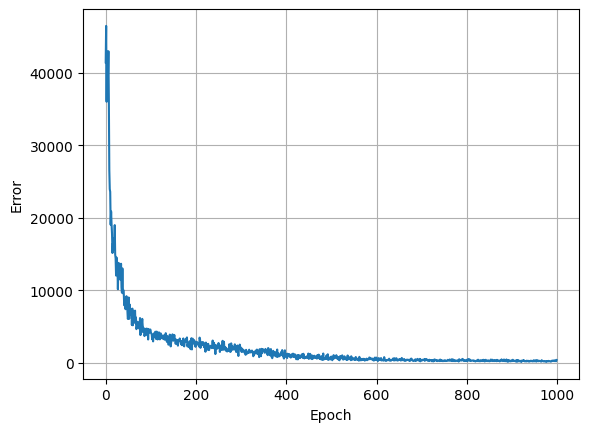

<Figure size 640x480 with 0 Axes>

In [42]:
plt.plot(losses_mynn1)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")

plt.figure()

In [43]:
class mynn2(nn.Module):
    def __init__(self):
        super().__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,100),
            nn.LeakyReLU(), # this is a different type of activation function
            nn.Linear(100,80),
            nn.LeakyReLU(), # it has a similar affect as nn.Sigmoid()
            nn.Linear(80,50),
            nn.LeakyReLU(), # But what is the key difference?
            nn.Linear(50,30),
            nn.LeakyReLU(),
            nn.Linear(30,1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

In [44]:
mynn2_model = mynn2().to(DEVICE)
mynn2_network, losses_mynn2 = train(XTrain, yTrain, mynn2_model, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:   20 training loss: 1.504e+04 time:    0.8
epoch:   40 training loss: 6.877e+03 time:    1.7
epoch:   60 training loss: 3.999e+03 time:    2.5
epoch:   80 training loss: 3.841e+03 time:    3.3
epoch:  100 training loss: 3.788e+03 time:    4.1
epoch:  120 training loss: 2.405e+03 time:    5.0
epoch:  140 training loss: 2.563e+03 time:    5.7
epoch:  160 training loss: 2.495e+03 time:    6.6
epoch:  180 training loss: 1.890e+03 time:    7.4
epoch:  200 training loss: 2.100e+03 time:    8.2
epoch:  220 training loss: 1.394e+03 time:    9.1
epoch:  240 training loss: 1.535e+03 time:   10.3
epoch:  260 training loss: 1.540e+03 time:   11.4
epoch:  280 training loss: 9.227e+02 time:   12.2
epoch:  300 training loss: 9.783e+02 time:   13.1
epoch:  320 training loss: 5.783e+02 time:   14.0
epoch:  340 training loss: 8.241e+02 time:   14.8
epoch:  360 training loss: 7.863e+02 time:   15.6
epoch:  380 training loss: 6.041e+02 time:   16.4
epoch:  400 training loss: 4.879e+02 time:   17.3


<Figure size 640x480 with 0 Axes>

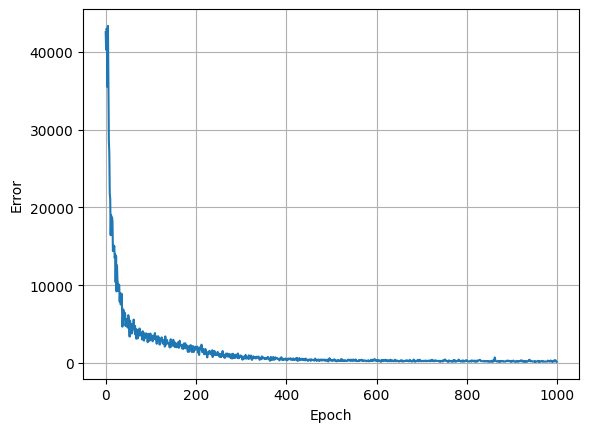

<Figure size 640x480 with 0 Axes>

In [45]:
plt.plot(losses_mynn2)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")

plt.figure()

In [46]:
class mynn3(nn.Module):
    def __init__(self):
        super().__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,100),
            nn.ReLU(), # this is a different type of activation function
            nn.Linear(100,80),
            nn.ReLU(), # it has a similar affect as nn.Sigmoid()
            nn.Linear(80,50),
            nn.ReLU(), # But what is the key difference?
            nn.Linear(50,30),
            nn.ReLU(),
            nn.Linear(30,10),
            nn.ReLU(),
            nn.Linear(10,1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

In [47]:
mynn3_model = mynn3().to(DEVICE)
mynn3_network, losses_mynn3 = train(XTrain, yTrain, mynn3_model, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:   20 training loss: 1.548e+04 time:    0.9
epoch:   40 training loss: 8.826e+03 time:    2.1
epoch:   60 training loss: 6.177e+03 time:    3.4
epoch:   80 training loss: 4.049e+03 time:    4.6
epoch:  100 training loss: 3.036e+03 time:    5.7
epoch:  120 training loss: 3.322e+03 time:    6.8
epoch:  140 training loss: 3.029e+03 time:    7.9
epoch:  160 training loss: 2.482e+03 time:    9.0
epoch:  180 training loss: 2.540e+03 time:   10.0
epoch:  200 training loss: 2.175e+03 time:   11.1
epoch:  220 training loss: 2.298e+03 time:   12.1
epoch:  240 training loss: 1.432e+03 time:   13.3
epoch:  260 training loss: 1.337e+03 time:   14.6
epoch:  280 training loss: 1.286e+03 time:   16.2
epoch:  300 training loss: 1.320e+03 time:   17.3
epoch:  320 training loss: 6.397e+02 time:   18.3
epoch:  340 training loss: 7.374e+02 time:   19.4
epoch:  360 training loss: 1.029e+03 time:   20.5
epoch:  380 training loss: 5.906e+02 time:   21.6
epoch:  400 training loss: 1.021e+03 time:   22.7


<Figure size 640x480 with 0 Axes>

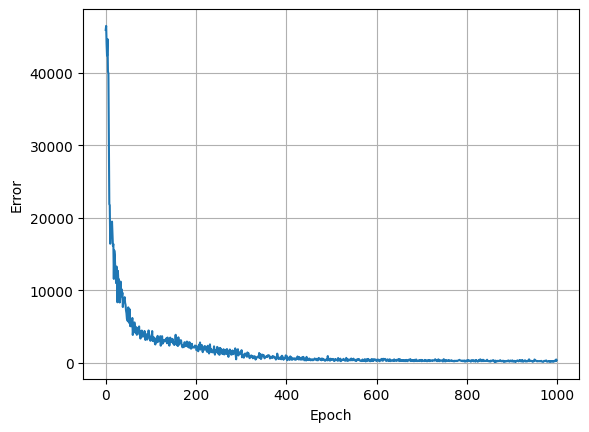

<Figure size 640x480 with 0 Axes>

In [48]:
plt.plot(losses_mynn3)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")

plt.figure()

In [49]:
MAE_train_my_nn_1,MSE_train_my_nn_1,RMSE_train_my_nn_1,R2_train_my_nn_1,MAE_test_my_nn_1,MSE_test_my_nn_1,RMSE_test_my_nn_1,R2_test_my_nn_1 = model_eva(XTrain,XTest,yTrain,yTest,mynn1_network)
MAE_train_my_nn_2,MSE_train_my_nn_2,RMSE_train_my_nn_2,R2_train_my_nn_2,MAE_test_my_nn_2,MSE_test_my_nn_2,RMSE_test_my_nn_2,R2_test_my_nn_2 = model_eva(XTrain,XTest,yTrain,yTest,mynn2_network)
MAE_train_my_nn_3,MSE_train_my_nn_3,RMSE_train_my_nn_3,R2_train_my_nn_3,MAE_test_my_nn_3,MSE_test_my_nn_3,RMSE_test_my_nn_3,R2_test_my_nn_3 = model_eva(XTrain,XTest,yTrain,yTest,mynn3_network)

In [50]:
results.append(["Your NN 1",MAE_train_my_nn_1,MSE_train_my_nn_1,RMSE_train_my_nn_1,R2_train_my_nn_1,MAE_test_my_nn_1,MSE_test_my_nn_1,RMSE_test_my_nn_1,R2_test_my_nn_1])
results.append(["Your NN 2",MAE_train_my_nn_2,MSE_train_my_nn_2,RMSE_train_my_nn_2,R2_train_my_nn_2,MAE_test_my_nn_2,MSE_test_my_nn_2,RMSE_test_my_nn_2,R2_test_my_nn_2])
results.append(["Your NN 3",MAE_train_my_nn_3,MSE_train_my_nn_3,RMSE_train_my_nn_3,R2_train_my_nn_3,MAE_test_my_nn_3,MSE_test_my_nn_3,RMSE_test_my_nn_3,R2_test_my_nn_3])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+---------------------------------------+----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+
| Model                                 |   Training MAE |    Training MSE |   Training RMSE |    Training R^2 |        Test MAE |         Test MSE |       Test RMSE |        Test R^2 |
+=======================================+================+=================+=================+=================+=================+==================+=================+=================+
| Linear Regression                     |      10776.9   |     1.89049e+08 |       13749.5   |    -0.811461    |     1.25807e+06 |      1.31444e+14 |     1.14649e+07 |    -0.000278576 |
+---------------------------------------+----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+
| KNeighbors Regressor (n_neighbors=20) |       6423.03  |     6.17881

# Deep Learning + Feature Engineering

Now you know what deep learning is. Can't we do some feature engineering to improve its performance?

![?](https://www.mememaker.net/static/images/memes/4751028.jpg)

Let's take a look at our data points again! Here's what an electric field measurement looks like when the transmitter is 15km away, i.e., at a range of 15 km.

<Figure size 640x480 with 0 Axes>

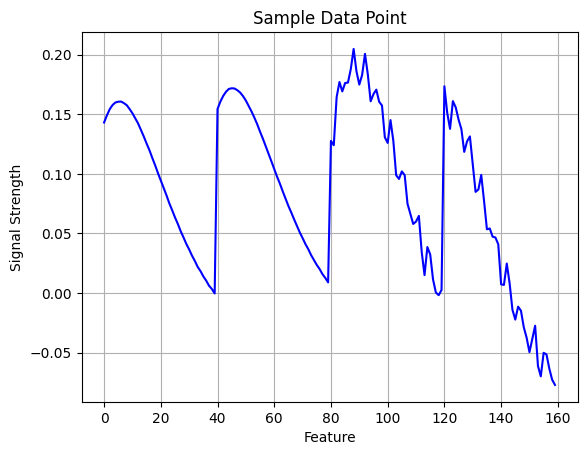

<Figure size 640x480 with 0 Axes>

In [51]:
plt.plot(XTrain[140], c='b')
plt.grid()
py.xlabel("Feature")
py.ylabel("Signal Strength")
py.title("Sample Data Point")
plt.figure()

Now let's take a look at something strange. Here is that same data point overlaid with the very next data point. We would expect these to be nearly identical.

<Figure size 640x480 with 0 Axes>

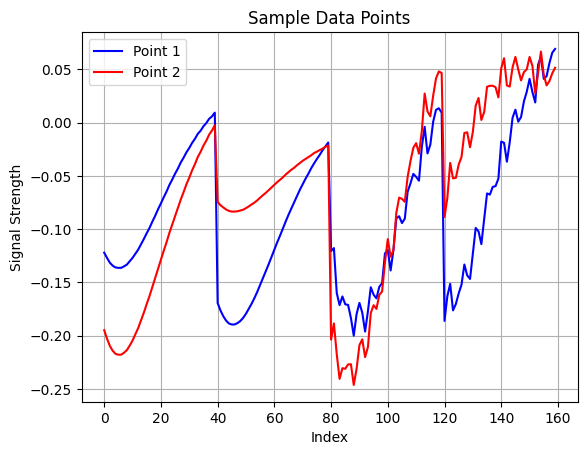

<Figure size 640x480 with 0 Axes>

In [52]:
plt.plot(x_norm[140], c='b', label='Point 1')
plt.plot(x_norm[141], c='r', label='Point 2')
plt.legend()
plt.grid()
py.xlabel("Index")
py.ylabel("Signal Strength")
py.title("Sample Data Points")
plt.figure()

If we really squint we might be able to see some similarity in shape, but really they're very different. This is a problem for network training. What's going on is that we're measuring a signal every 50m when it's oscillating at the scale of centimeters. It's as if we're measuring a sin wave at the integers, i.e. sin(1), sin(2), sin(3), etc. It'll look like we're generating random numbers even though we're measuring something specific.

We need to do some feature engineering!

To account for this all we need to do is rotate the complex numbers that make up the vector. What we do is compute the angle of the very first complex entry in the vector. We rotate the entire vector by the exact angle that makes the first entry positive real.

As a formula, we're doing this:

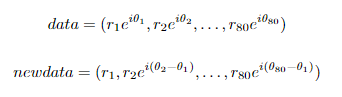

In [53]:
def rotate(normedX):

    rows = normedX.shape[0]
    cols = normedX.shape[1]

    #rotate back
    angle_h = np.arctan(normedX[:,40]/normedX[:,0]).reshape((rows, 1))
    angle_v = np.arctan(normedX[:,120]/normedX[:,80]).reshape((rows, 1))

    realparts_h = normedX[:,0:40]
    imagparts_h = normedX[:,40:80]


    output = np.zeros_like(normedX)

    output[:,0:40] = np.cos(angle_h)*realparts_h + np.sin(angle_h) * imagparts_h
    output[:,40:80] = -np.sin(angle_h)*realparts_h + np.cos(angle_h) * imagparts_h


    realparts_v = normedX[:,80:120]
    imagpart_v = normedX[:,120:160]
    output[:,80:120] = np.cos(angle_v)*realparts_v + np.sin(angle_v) * imagpart_v
    output[:,120:160] = -np.sin(angle_v)*realparts_v + np.cos(angle_v) * imagpart_v

    output[:,0:80] = np.sign(output[:,0]).reshape((rows,1)) * output[:,0:80]
    output[:,80:160] = np.sign(output[:,80]).reshape((rows,1)) * output[:,80:160]

    return output

Let's take another look at our data once we apply this rotation:

<Figure size 640x480 with 0 Axes>

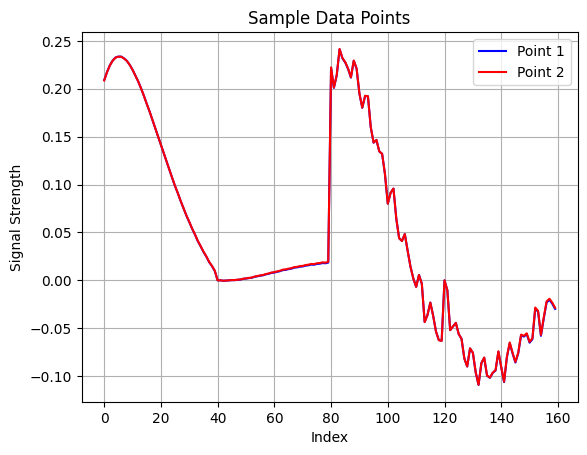

<Figure size 640x480 with 0 Axes>

In [54]:
plt.plot(rotate(x_norm)[140], c='b', label='Point 1')
plt.plot(rotate(x_norm)[141], c='r', label='Point 2')
plt.legend()
plt.grid()
py.xlabel("Index")
py.ylabel("Signal Strength")
py.title("Sample Data Points")
plt.figure()

Now they're nearly identical! This might be good for our network training - it's easier to train if similar inputs lead to similar outputs.

## **Question 7** **(10 points)**

**Part 1 (10 points)**

Design and train a NN with rotated data `X`, you should be able to get a good result by turning your hyperparameters (`batch size`, `number of epochs`, `learning rate`).

Hint:

XTrain_rotated=rotate(XTrain)

XTest_rotated=rotate(XTest)

model_r = YourNetwork().cuda()

batch_size = 50, 100, 200

num_epochs = 500,1000, 2000

learning_rate = 1e-2, 1e-3, 1e-4

criterion = nn.MSELoss()

network_r, losses = train(XTrain_rotated, yTrain, model_r, num_epochs, learning_rate, batch_size, criterion, print_interval)


In [55]:
class mynnrotated(nn.Module):
    def __init__(self):
        super().__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,100),
            nn.ReLU(), # this is a different type of activation function
            nn.Linear(100,80),
            nn.ReLU(), # it has a similar affect as nn.Sigmoid()
            nn.Linear(80,50),
            nn.ReLU(), # But what is the key difference?
            nn.Linear(50,30),
            nn.ReLU(),
            nn.Linear(30,1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

In [56]:
torch.manual_seed(50) # this makes results reproducable
batch_size = 128
num_epochs = 1000
learning_rate = 1e-3
criterion = nn.MSELoss()

In [57]:
XTrain_rotated=rotate(XTrain)
XTest_rotated=rotate(XTest)

In [58]:
mynn_model_rotated = mynnrotated().to(DEVICE)
mynn_network_rotated, losses_mynn_rotated = train(XTrain_rotated, yTrain, mynn_model_rotated, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:   20 training loss: 4.270e+04 time:    0.3
epoch:   40 training loss: 1.431e+04 time:    0.6
epoch:   60 training loss: 1.106e+04 time:    1.0
epoch:   80 training loss: 9.659e+03 time:    1.3
epoch:  100 training loss: 1.013e+04 time:    1.6
epoch:  120 training loss: 9.324e+03 time:    1.9
epoch:  140 training loss: 9.175e+03 time:    2.2
epoch:  160 training loss: 9.351e+03 time:    2.5
epoch:  180 training loss: 9.306e+03 time:    2.9
epoch:  200 training loss: 8.337e+03 time:    3.4
epoch:  220 training loss: 6.658e+03 time:    3.9
epoch:  240 training loss: 7.618e+03 time:    4.4
epoch:  260 training loss: 6.821e+03 time:    5.0
epoch:  280 training loss: 7.024e+03 time:    5.4
epoch:  300 training loss: 6.613e+03 time:    5.8
epoch:  320 training loss: 6.098e+03 time:    6.2
epoch:  340 training loss: 7.520e+03 time:    6.6
epoch:  360 training loss: 6.781e+03 time:    7.0
epoch:  380 training loss: 6.605e+03 time:    7.4
epoch:  400 training loss: 6.134e+03 time:    7.9


<Figure size 640x480 with 0 Axes>

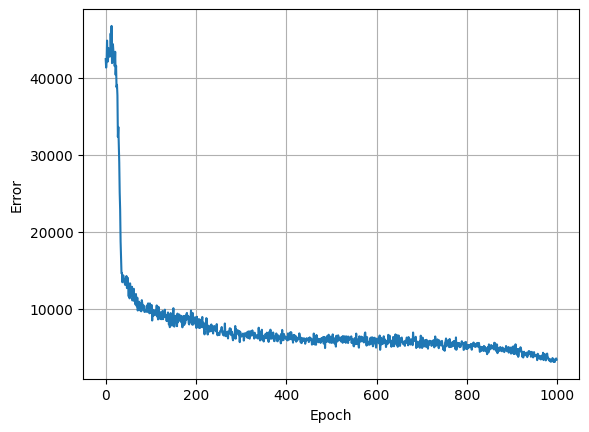

<Figure size 640x480 with 0 Axes>

In [59]:
plt.plot(losses_mynn_rotated)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")

plt.figure()

In [60]:
MAE_train_my_nn_rotated,MSE_train_my_nn_rotated,RMSE_train_my_nn_rotated,R2_train_my_nn_rotated,MAE_test_my_nn_rotated,MSE_test_my_nn_rotated,RMSE_test_my_nn_rotated,R2_test_my_nn_rotated = model_eva(XTrain_rotated,XTest_rotated,yTrain,yTest,mynn_network_rotated)

In [61]:
results.append(["Your NN with rotated X",MAE_train_my_nn_rotated,MSE_train_my_nn_rotated,RMSE_train_my_nn_rotated,R2_train_my_nn_rotated,MAE_test_my_nn_rotated,MSE_test_my_nn_rotated,RMSE_test_my_nn_rotated,R2_test_my_nn_rotated])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+---------------------------------------+----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+
| Model                                 |   Training MAE |    Training MSE |   Training RMSE |    Training R^2 |        Test MAE |         Test MSE |       Test RMSE |        Test R^2 |
+=======================================+================+=================+=================+=================+=================+==================+=================+=================+
| Linear Regression                     |      10776.9   |     1.89049e+08 |       13749.5   |    -0.811461    |     1.25807e+06 |      1.31444e+14 |     1.14649e+07 |    -0.000278576 |
+---------------------------------------+----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+
| KNeighbors Regressor (n_neighbors=20) |       6423.03  |     6.17881

# Cross weather evaluation.

Next, we want to see how well this model would perform on new kinds of data.

There's a huge part of this problem that we haven't discussed yet - the weather conditions make an enormous difference when it comes to the electric field! In particular, the most important of these weather conditions is the evaporation duct we mentioned earlier. Recall that the duct traps the signal, the signal bounces around in the duct, and that allows us to get good range predictions. The key difficulty in this problem is that the electric field you get when the duct is 20 meters tall is very very different from the electric field you get when the duct is 25 meters tall. All the data we've used so far comes from a 25 meter duct.

There's a crucial question here - **if the weather today is different from the weather yesterday, can we still make good range predictions?**

Imagine the following: we go out one day and collect training data for this problem, and the weather for that day was such that the evaporation duct was 25m tall. We train our neural network and make great predictions. The next day, we try to go out and use our neural network in the field to make range predictions, but the weather is different - the duct height is 24m. Can we still do a good job? We need to figure out what kind of performance we can expect in different weather conditions.

The next file has some electric field data for different weather conditions.

Our previous data set was 1 electric field coming from a duct height of 25m. This next data set has 4 electric fields coming from duct heights of 23, 23.5, 24, and 24.5 meters. Let's test and see how well our network does on these data sets.

Let's load new data for the evaluation.

In [62]:
arrays2 = {}

filepath = ['cs3data2.h5']
numfiles = len(filepath)
f = 0
for i in range(numfiles):
    f = h5py.File(filepath[i], 'r')
    for k, v in f.items():
        arrays2[k] = v

# display what data we have
for key in arrays2.keys():
    print(key, arrays2[key])

duct_height_save <HDF5 dataset "duct_height_save": shape (1, 4), type "<f8">
field_H_imag_save <HDF5 dataset "field_H_imag_save": shape (4, 1201, 40), type "<f8">
field_H_real_save <HDF5 dataset "field_H_real_save": shape (4, 1201, 40), type "<f8">
field_V_imag_save <HDF5 dataset "field_V_imag_save": shape (4, 1201, 40), type "<f8">
field_V_real_save <HDF5 dataset "field_V_real_save": shape (4, 1201, 40), type "<f8">
range_grid <HDF5 dataset "range_grid": shape (1201, 1), type "<f8">


In [63]:
# what are our new test duct heights?
duct_heights = np.array(arrays2['duct_height_save']).reshape(-1)
print(duct_heights)

[23.  23.5 24.  24.5]


In [64]:
numfields =  4
numranges = 1201

#get the electric field data and reshape everything into one np array

test_data_h_real = np.array(arrays2['field_H_real_save']).reshape(numfields, numranges, 40)
test_data_h_imag = np.array(arrays2['field_H_imag_save']).reshape(numfields, numranges, 40)
test_data_v_real = np.array(arrays2['field_V_real_save']).reshape(numfields, numranges, 40)
test_data_v_imag = np.array(arrays2['field_V_imag_save']).reshape(numfields, numranges, 40)

XTest_otherducts = []
XTest_otherducts += [[test_data_h_real*1, test_data_h_imag*1, test_data_v_real*1, test_data_v_imag*1]]
XTest_otherducts = np.block(XTest_otherducts)
print(XTest_otherducts.shape)

# get the target range data

ranges = np.array(arrays2['range_grid']).reshape((numranges))

yTest_otherducts = []
yTest_otherducts += [ranges]
yTest_otherducts = np.block(yTest_otherducts)
print(yTest_otherducts.shape)

(4, 1201, 160)
(1201,)


Let test our network on all 4 of these data sets.

In [65]:
MAE_train_nn3_w1,MSE_train_nn3_w1,RMSE_train_nn3_w1,R2_train_nn3_w1,MAE_test_nn3_w1,MSE_test_nn3_w1,RMSE_test_nn3_w1,R2_test_nn3_w1 = model_eva(XTrain,normalize(XTest_otherducts[0]),yTrain,yTest_otherducts,network_3)
MAE_train_nn3_w2,MSE_train_nn3_w2,RMSE_train_nn3_w2,R2_train_nn3_w2,MAE_test_nn3_w2,MSE_test_nn3_w2,RMSE_test_nn3_w2,R2_test_nn3_w2 = model_eva(XTrain,normalize(XTest_otherducts[1]),yTrain,yTest_otherducts,network_3)
MAE_train_nn3_w3,MSE_train_nn3_w3,RMSE_train_nn3_w3,R2_train_nn3_w3,MAE_test_nn3_w3,MSE_test_nn3_w3,RMSE_test_nn3_w3,R2_test_nn3_w3 = model_eva(XTrain,normalize(XTest_otherducts[2]),yTrain,yTest_otherducts,network_3)
MAE_train_nn3_w4,MSE_train_nn3_w4,RMSE_train_nn3_w4,R2_train_nn3_w4,MAE_test_nn3_w4,MSE_test_nn3_w4,RMSE_test_nn3_w4,R2_test_nn3_w4 = model_eva(XTrain,normalize(XTest_otherducts[3]),yTrain,yTest_otherducts,network_3)

In [66]:
results.append(["NN_3_weather_1",MAE_train_nn3_w1,MSE_train_nn3_w1,RMSE_train_nn3_w1,R2_train_nn3_w1,MAE_test_nn3_w1,MSE_test_nn3_w1,RMSE_test_nn3_w1,R2_test_nn3_w1])
results.append(["NN_3_weather_2",MAE_train_nn3_w2,MSE_train_nn3_w2,RMSE_train_nn3_w2,R2_train_nn3_w2,MAE_test_nn3_w2,MSE_test_nn3_w2,RMSE_test_nn3_w2,R2_test_nn3_w2])
results.append(["NN_3_weather_3",MAE_train_nn3_w3,MSE_train_nn3_w3,RMSE_train_nn3_w3,R2_train_nn3_w3,MAE_test_nn3_w3,MSE_test_nn3_w3,RMSE_test_nn3_w3,R2_test_nn3_w3])
results.append(["NN_3_weather_4",MAE_train_nn3_w4,MSE_train_nn3_w4,RMSE_train_nn3_w4,R2_train_nn3_w4,MAE_test_nn3_w4,MSE_test_nn3_w4,RMSE_test_nn3_w4,R2_test_nn3_w4])

In [67]:
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+---------------------------------------+----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+
| Model                                 |   Training MAE |    Training MSE |   Training RMSE |    Training R^2 |        Test MAE |         Test MSE |       Test RMSE |        Test R^2 |
+=======================================+================+=================+=================+=================+=================+==================+=================+=================+
| Linear Regression                     |      10776.9   |     1.89049e+08 |       13749.5   |    -0.811461    |     1.25807e+06 |      1.31444e+14 |     1.14649e+07 |    -0.000278576 |
+---------------------------------------+----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+
| KNeighbors Regressor (n_neighbors=20) |       6423.03  |     6.17881

## **Question 8** **(20 points)**

**Part 1 (5 points)**

What are your observations here? Does the model perform well in all different weather?

Based on the provided results for NN_3_weather_1 to NN_3_weather_4, we can conclude the following:

Training Performance: All models exhibit similar performance metrics in terms of MAE, MSE, RMSE, and R^2 on the training set.

Testing Performance: When evaluating on the test set, we notice that NN_3_weather_4 achieves the lowest MAE, MSE, and RMSE on the test set, indicating better generalization compared to the other 3 models.

Model Robustness: The model architectures or training methods employed in NN_3_weather_3 and NN_3_weather_4 might be more robust and better suited for handling variations in weather conditions.

R^2 Score: The R^2 scores for the test set are positive for all models, however, NN_3_weather_4 achieves the highest R^2 score among all models, implying better overall fit to the data.

In summary, NN_3_weather_4 stands out as the superior model in terms of generalization and robustness across different weather conditions.


**Part 1 (15 points)**

Merge all data of different weather together, and then retrain the model. Can you acheive a better performance? Report you results.

Hint:

Using `np.concatenate` to merge to data. eg,
```python
XTrain_all = np.concatenate([XTrain1, XTrain2])
```

Comparing these results with the previous models, we notice a slight improvement in performance metrics across both the training and test sets. NN_3_weather_all achieves lower MAE, MSE, and RMSE values on both sets, indicating better accuracy and fit to the data. Additionally, the R^2 scores for NN_3_weather_all are very close to 1, indicating an excellent fit.

In [69]:
import numpy as np
XTrain_all = np.concatenate([XTrain, normalize(XTest_otherducts[0])])
yTrain_all = np.concatenate([yTrain, yTest_otherducts])
XTrain_all = np.concatenate([XTrain_all, normalize(XTest_otherducts[1])])
yTrain_all = np.concatenate([yTrain_all, yTest_otherducts])
XTrain_all = np.concatenate([XTrain_all, normalize(XTest_otherducts[2])])
yTrain_all = np.concatenate([yTrain_all, yTest_otherducts])
XTrain_all = np.concatenate([XTrain_all, normalize(XTest_otherducts[3])])
yTrain_all = np.concatenate([yTrain_all, yTest_otherducts])

network_3_all = mynn3().to(DEVICE)
batch_size = 128
num_epochs = 1000
learning_rate = 1e-3
criterion = nn.MSELoss()
network_3_all, losses_network_3_all = train(XTrain_all, yTrain_all, network_3_all, num_epochs, learning_rate, batch_size, criterion, print_interval)

MAE_train_nn3_all,MSE_train_nn3_all,RMSE_train_nn3_all,R2_train_nn3_all,MAE_test_nn3_all,MSE_test_nn3_all,RMSE_test_nn3_all,R2_test_nn3_all = model_eva(XTrain_all,normalize(XTest_otherducts[0]),yTrain_all,yTest_otherducts,network_3_all)
results.append(["NN_3_weather_all",MAE_train_nn3_all,MSE_train_nn3_all,RMSE_train_nn3_all,R2_train_nn3_all,MAE_test_nn3_all,MSE_test_nn3_all,RMSE_test_nn3_all,R2_test_nn3_all])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))


epoch:   20 training loss: 6.213e+03 time:    3.3
epoch:   40 training loss: 3.473e+03 time:    6.4
epoch:   60 training loss: 3.345e+03 time:   10.5
epoch:   80 training loss: 2.040e+03 time:   14.9
epoch:  100 training loss: 1.105e+03 time:   19.1
epoch:  120 training loss: 6.861e+02 time:   22.7
epoch:  140 training loss: 1.086e+03 time:   27.4
epoch:  160 training loss: 5.507e+02 time:   30.9
epoch:  180 training loss: 7.613e+02 time:   34.5
epoch:  200 training loss: 7.411e+02 time:   38.9
epoch:  220 training loss: 4.150e+02 time:   42.6
epoch:  240 training loss: 5.400e+02 time:   46.2
epoch:  260 training loss: 4.500e+02 time:   50.5
epoch:  280 training loss: 5.130e+02 time:   54.1
epoch:  300 training loss: 4.994e+02 time:   58.4
epoch:  320 training loss: 3.935e+02 time:   62.7
epoch:  340 training loss: 4.376e+02 time:   66.3
epoch:  360 training loss: 3.662e+02 time:   69.9
epoch:  380 training loss: 4.654e+02 time:   74.4
epoch:  400 training loss: 4.782e+02 time:   78.0


## **Question 9** **($\infty$ points, since this is where you really learn stuff! :-)**

You can get as many points of extra credit as you like by doing a good job with this question!

Play around with doing a better analysis.  Things to try:

1.   We already know the power of neural networks, so is it possible to overfit them? How can we prevent the overfitting of neural networks? There are two common techniques widely used for regularization: Dropout and Batch Normalization. Try to use them in your networks, do the networks perform better than others?
Here are several examples in Pytorch:
https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html,
https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html


2.  The Real-world signals are often noisy, can we add Gaussian noise to our training samples to simulate the signal and improve model performance? You might get inspiration from the paper [Deep Learning for Range Localization via Over-Water Electromagnetic Signals](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9680246). Try to do some feature engineering and report your results. If you have any great ideas, please don't hesitate to tell Randy 🧙, he can help you publish a paper at top conferences and shine your resume. 👀




